# Overfitting Crab Age

*In which we practice one thing so much that we get worse at everything else.*


### Define Constants


In [74]:
CACHE_FILE = '../cache/crabs.feather'
NEXT_NOTEBOOK = '../1-models/models.ipynb'

PREDICTION_TARGET = 'Age'    # 'Age' is predicted
DATASET_COLUMNS = ['Sex_F','Sex_M','Sex_I','Length','Diameter','Height','Weight','Shucked Weight','Viscera Weight','Shell Weight',PREDICTION_TARGET]
REQUIRED_COLUMNS = [PREDICTION_TARGET]

MODEL_CHECKPOINT_FILE = '../cache/overfit_model.weights.h5'


### Import Libraries

PyTorch supports windows-native CUDA, but TensorFlow on CPU was faster for this task.


In [75]:
from notebooks.time_for_crab.mlutils import display_df, plot_training_loss, score_combine, score_comparator, score_model

import keras

keras_backend = keras.backend.backend()
print(f'Keras version: {keras.__version__}')
print(f'Keras backend: {keras_backend}')
if keras_backend == 'tensorflow':
    import tensorflow as tf
    print(f'TensorFlow version: {tf.__version__}')
    print(f'TensorFlow devices: {tf.config.list_physical_devices()}')
elif keras_backend == 'torch':
    import torch
    print(f'Torch version: {torch.__version__}')
    print(f'Torch devices: {torch.cuda.get_device_name(torch.cuda.current_device())}')
    # torch supports windows-native cuda, but CPU was faster for this task

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

pd.set_option('mode.copy_on_write', True)


Keras version: 3.3.3
Keras backend: tensorflow
TensorFlow version: 2.16.1
TensorFlow devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


### Load Data from Cache

In the [previous section](../0-eda/eda.ipynb), we saved the cleaned data to a cache file. Let's load it back.


In [76]:
crabs = pd.read_feather(CACHE_FILE)
display_df(crabs)


DataFrame shape: (3790, 11)
First 5 rows:
     Length  Diameter    Height     Weight  Shucked Weight  Viscera Weight  \
0  1.437500  1.174805  0.412598  24.640625       12.335938        5.585938   
1  0.887695  0.649902  0.212524   5.402344        2.296875        1.375000   
2  1.037109  0.774902  0.250000   7.953125        3.232422        1.601562   
3  1.174805  0.887695  0.250000  13.476562        4.750000        2.281250   
4  0.887695  0.662598  0.212524   6.902344        3.458984        1.488281   

   Shell Weight  Age  Sex_F  Sex_I  Sex_M  
0      6.746094    9   True  False  False  
1      1.559570    6  False  False   True  
2      2.763672    6  False   True  False  
3      5.246094   10   True  False  False  
4      1.701172    6  False   True  False  
<class 'pandas.core.frame.DataFrame'>
Index: 3790 entries, 0 to 3892
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Length          3790 non-nul

## Overfitting Crab Age

![Large mud crab measure](https://upload.wikimedia.org/wikipedia/commons/thumb/6/65/CSIRO_ScienceImage_10696_Mud_crabs_are_caught_measured_tagged_and_released_as_part_of_the_research_into_the_effectiveness_of_green_zones_in_Moreton_Bay.jpg/1920px-CSIRO_ScienceImage_10696_Mud_crabs_are_caught_measured_tagged_and_released_as_part_of_the_research_into_the_effectiveness_of_green_zones_in_Moreton_Bay.jpg)


### Overfitting Goals and Methods 

The goal here is to show how complex of a model it will take to overfit the data.

We will use the following methods to overfit the data:

1. **Linear Regression**: Gradually increase the complexity of a linear regression model.
2. **Model Stacking**: Stack models to overfit the model.

I am following the TensorFlow tutorial on [Linear Regression](https://www.tensorflow.org/tutorials/keras/regression#linear_regression_with_one_variable) to build the linear regression model.

> There are two steps in your single-variable linear regression model:  
>    1. Normalize the 'Horsepower' input features using the tf.keras.layers.Normalization preprocessing layer.
>    2. Apply a linear transformation ($y = mx + b$) to produce 1 output using a linear layer (tf.keras.layers.Dense).

Instead of 'Horsepower', we'll use 'Shell Weight' as our regression variable.


## Build the Shell Weight Model

This is a simple linear regression model that predicts the age of a crab based on its shell weight. It remains untrained.


#### Layer: Input Layer

This defines the shape of our input to the model.


In [77]:
shell_weight_input = keras.layers.Input(shape=(1,))


#### Layer: Shell Weight Normalizer Layer

This is a quick and easy way to normalize our input data.

***Note**: In later steps, we will use a custom normalizer to show how it's done.*


In [78]:
shell_weight = np.array(crabs['Shell Weight'])
shell_weight_normalizer = keras.layers.Normalization(axis=None)
shell_weight_normalizer.adapt(shell_weight)


#### Layer: Dense Layer

This is the layer that will perform the linear regression.


In [79]:
shell_weight_dense = keras.layers.Dense(units=1)


### Architecture: Bringing it All Together

Now we'll put all the layers together to create the model. It is still going to be untrained.


In [80]:
shell_weight_model = keras.Sequential([
    shell_weight_input,
    shell_weight_normalizer,
    shell_weight_dense
])

shell_weight_model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_5 (Normalization) │ (None, 1)              │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5 (24.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 3 (16.00 B)

### Pre-Training Predictions (For Science)

We don't expect good results here. This is just to get a baseline.



In [81]:
shell_weight_target = np.array(crabs[PREDICTION_TARGET])
shell_weight_preds = shell_weight_model.predict(shell_weight).flatten()

print(shell_weight_target)
print(shell_weight_preds)


119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step
[9 6 6 ... 5 6 8]
[-0.01330429  0.5219918   0.39771765 ...  0.6171377   0.37574542
  0.53670716]


#### Scores: Naive Model

Throughout this notebook, we will use the following metrics to evaluate the regression model:

- **Mean Squared Error**
    - The best possible score is 0.0, lower values are better.
- **Mean Absolute Error**
    - The best possible score is 0.0, lower values are better. Less sensitive to outliers.
- **Explained Variance Score**
    - The best possible score is 1.0, lower values are worse.
- **R2 Score**
    - The best possible score is 1.0, lower values are worse.
- **Max Error**
    - The max error is the worst possible score. Domain-specific. 10 years is a lot for a crab.
 

In [82]:
# Utility functions imported from mlutils.py
naive_scores_df = score_model(shell_weight_preds, shell_weight_target, index='naive')
naive_scores_df.head()


,mean_squared_error,mean_absolute_error,explained_variance_score,r2_score,max_error
naive,104.776642,9.741818,-64.196121,-690.847528,20.256891


#### Observations: Naive Model

As expected, the untrained scores are terrible.


### Prepare the Shell Weight Model

Now it's finally time to get learning!

#### Compile

We will use the mean squared error as the loss function and the Adam optimizer.


In [83]:
shell_weight_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_squared_error'
)


#### Checkpoint the Shell Weight Model

We want to save the model for later reference.


In [84]:
shell_weight_checkpoint = keras.callbacks.ModelCheckpoint(
    MODEL_CHECKPOINT_FILE.replace('overfit', 'shell_weight'),
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    mode='min'
)


### Train the Shell Weight Model

Let's train for 100 epochs.


In [85]:
%%time
history = shell_weight_model.fit(
    x=crabs['Shell Weight'],
    y=crabs[PREDICTION_TARGET],
    epochs=100,
    verbose=0,
    validation_split=0.2,
    callbacks=[shell_weight_checkpoint]
)


CPU times: total: 2.17 s
Wall time: 7.84 s


#### Plot Training History


In [86]:
history_df = pd.DataFrame(history.history)
history_df['epoch'] = history.epoch
history_df.tail()


,loss,val_loss,epoch
95,5.148976,5.081877,95
96,5.143148,5.034345,96
97,5.188433,4.996866,97
98,5.171146,5.014950,98
99,5.173080,4.986612,99


#### Plot Loss History


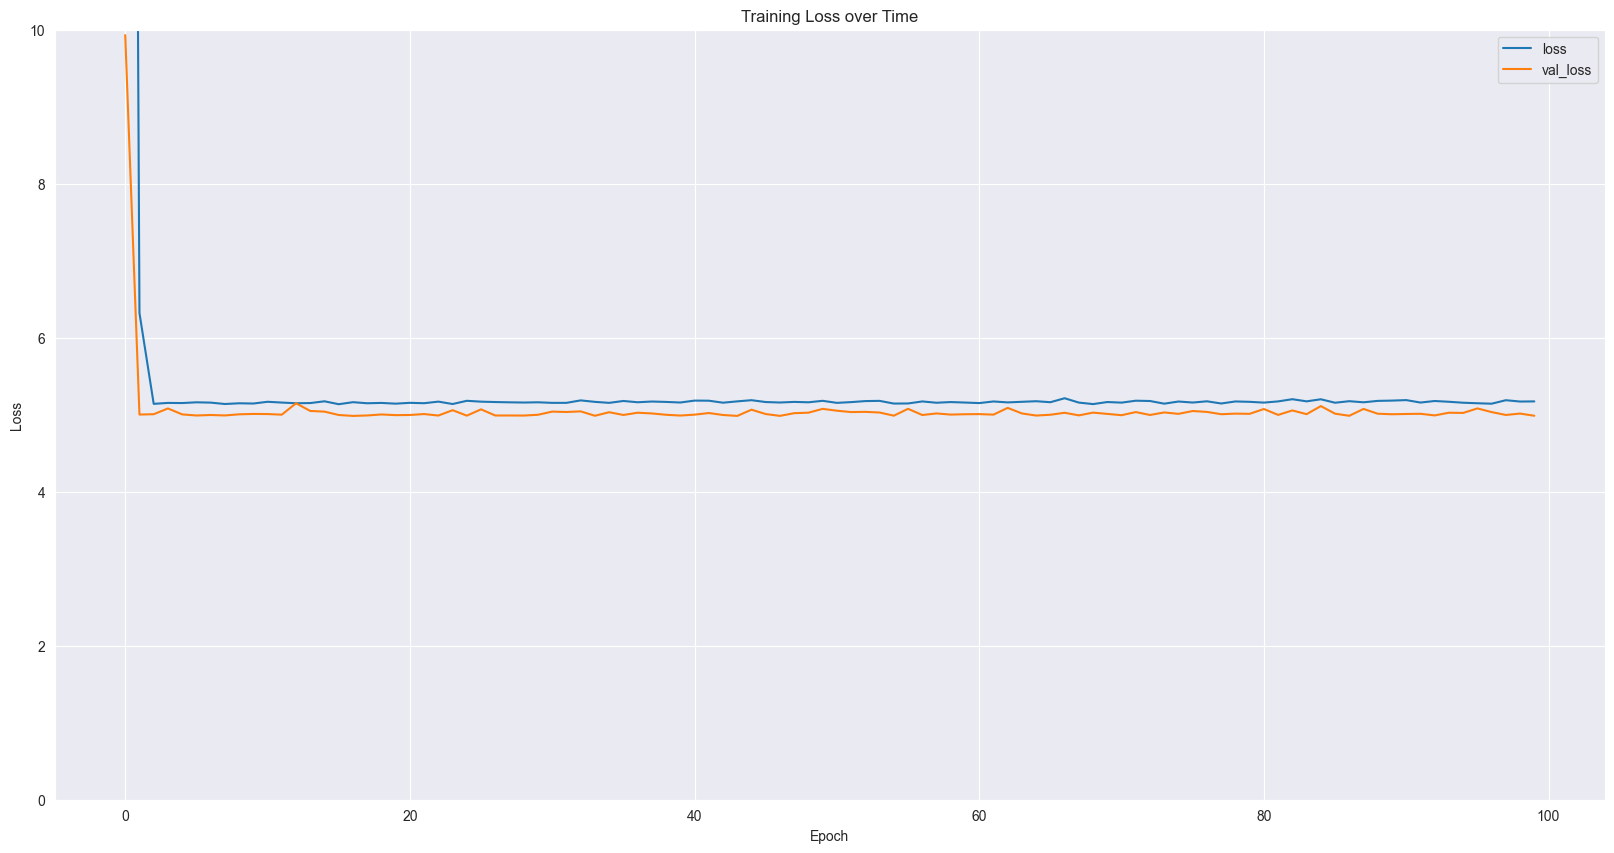

In [87]:
# Utility functions imported from mlutils.py
plot_training_loss(history)


#### View the Line of Best Fit

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


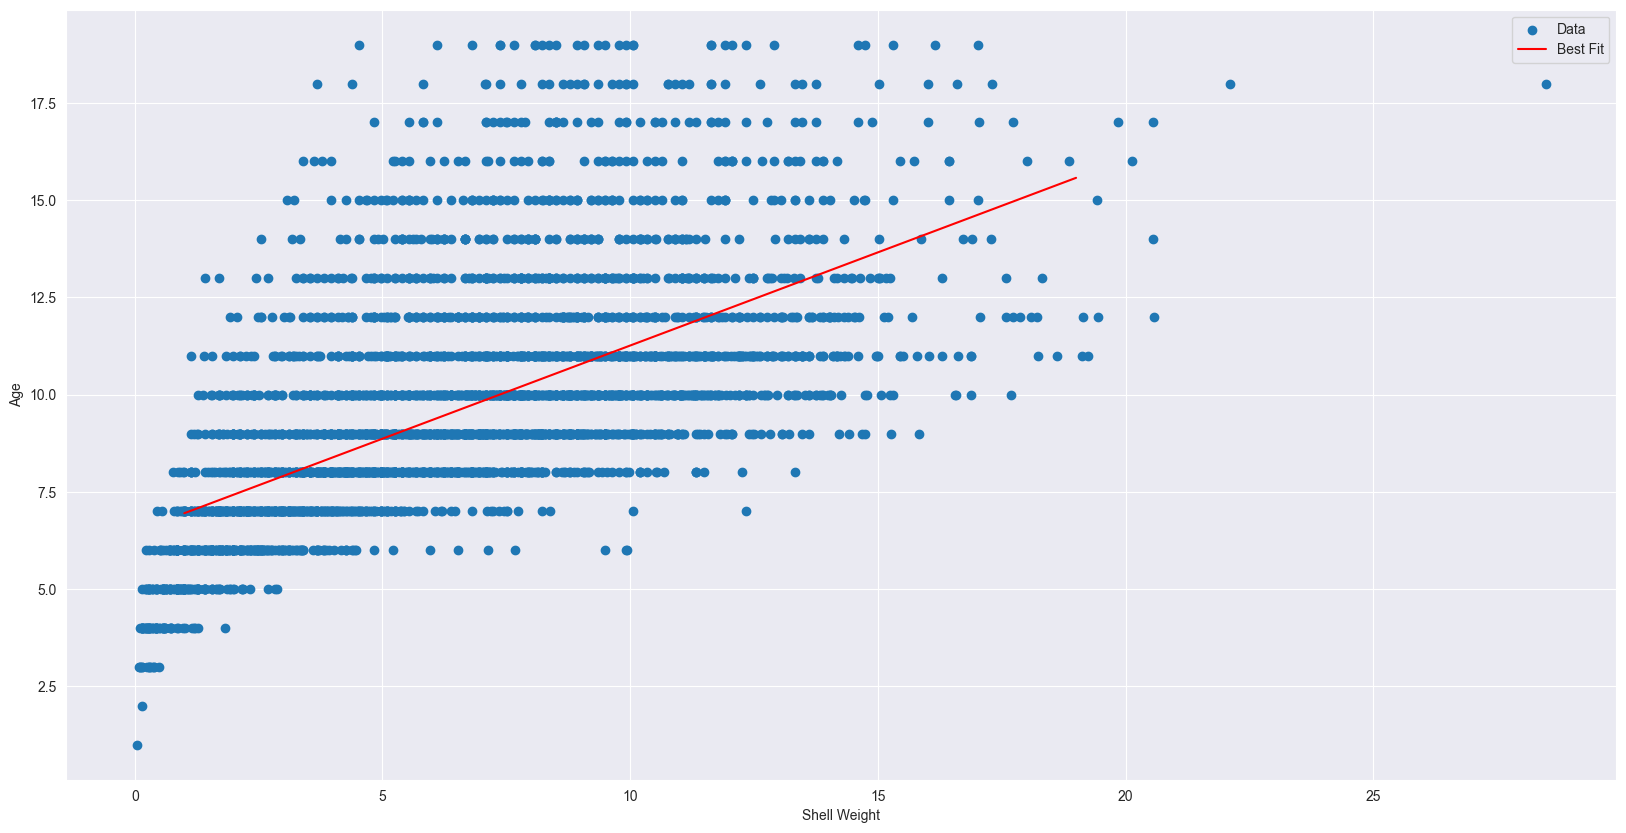

In [88]:
x = np.linspace(crabs['Age'].min(), crabs['Age'].max(), 100)
y = shell_weight_model.predict(x).flatten()

plt.figure(figsize=(20, 10))
plt.scatter(crabs['Shell Weight'], crabs['Age'], label='Data')
plt.plot(x, y, color='red', label='Best Fit')
plt.xlabel('Shell Weight')
plt.ylabel('Age')
plt.legend()
plt.show()


### Predictions: Shell Weight Model

Now that we've trained the model, let's see how it performs.

We are hoping for almost 100% accuracy or zero error to achieve overfitting. However, we are not expecting this to happen just yet.

We have only trained the model on one feature, 'Shell Weight'. It is unlikely that just one feature (*except maybe the target itself*) will be able to overfit the data.


In [89]:
shell_weight_target = np.array(crabs[PREDICTION_TARGET])
shell_weight_preds = shell_weight_model.predict(shell_weight).flatten()

print(shell_weight_target)
print(shell_weight_preds)


119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step
[9 6 6 ... 5 6 8]
[9.705834  7.2207727 7.797704  ... 6.779067  7.8997083 7.152458 ]


#### Scores: Shell Weight Model

Reminder of our metrics:

- **Mean Squared Error**
    - The best possible score is 0.0, lower values are better.
- **Mean Absolute Error**
    - The best possible score is 0.0, lower values are better. Less sensitive to outliers.
- **Explained Variance Score**
    - The best possible score is 1.0, lower values are worse.
- **R2 Score**
    - The best possible score is 1.0, lower values are worse.
- **Max Error**
    - The max error is the worst possible score. Domain-specific. 10 years is a lot for a crab.
 

In [90]:
# Utility functions imported from mlutils.py
shell_weight_scores_df = score_model(shell_weight_preds, shell_weight_target, index='shell_weight')

leaderboard_df = score_combine(naive_scores_df, shell_weight_scores_df)

leaderboard_df.head()


,mean_squared_error,mean_absolute_error,explained_variance_score,r2_score,max_error
naive,104.776642,9.741818,-64.196121,-690.847528,20.256891
shell_weight,5.109282,1.674861,-0.562407,-0.565380,10.353510


#### Comparison: Naive vs Shell Weight

<Axes: title={'center': 'Naive vs Trained Model Scores'}>

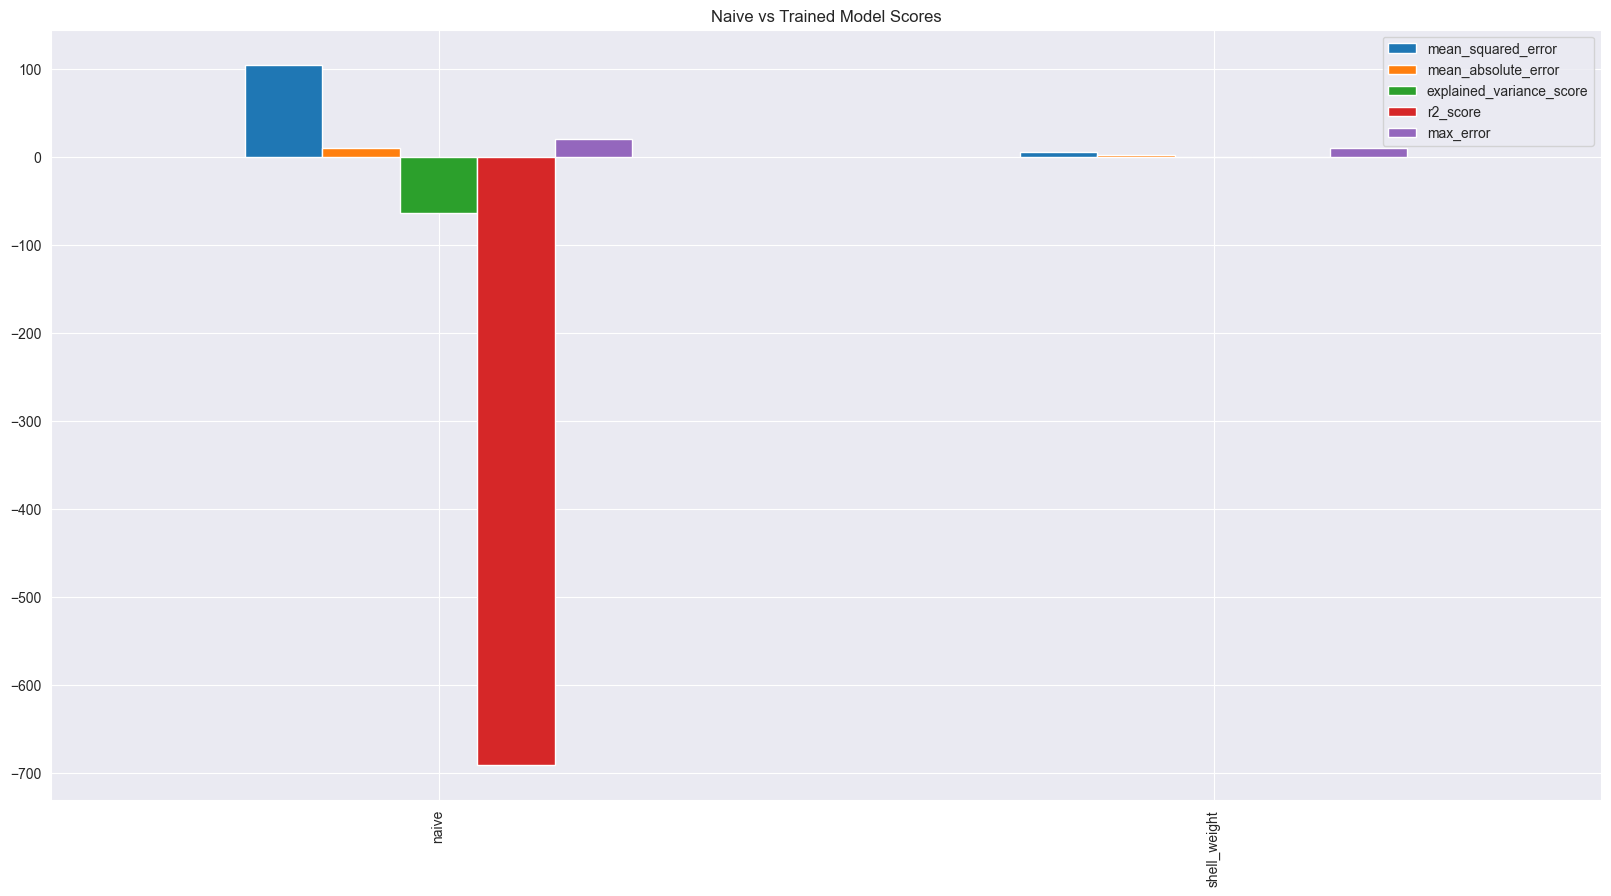

In [91]:
leaderboard_df.plot(kind='bar', title='Naive vs Trained Model Scores', figsize=(20, 10))


#### Score-by-Score Comparison: Naive vs Shell Weight

Break down the bar charts into one for each metric.


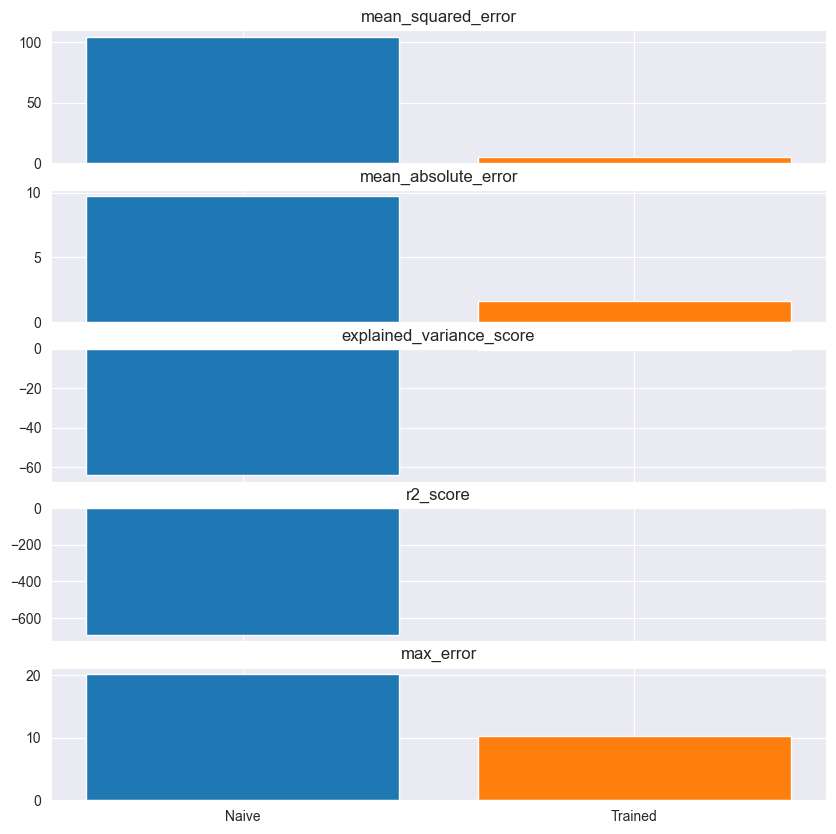

In [92]:
# Utility functions imported from mlutils.py
score_comparator(naive_scores_df, shell_weight_scores_df, train_label='Naive', test_label='Trained')


### Observations: Shell Weight Model

The scores are much better after training! But not even close to overfitting the data.

Shell Weight alone must not be a good predictor of crab age.


## Build the Feature-Rich Model

Moving on to [linear regression with multiple variables](https://www.tensorflow.org/tutorials/keras/regression#linear_regression_with_multiple_inputs).

In order to overfit, we're going to need to give the model more features from the dataset.

Shell Weight alone is not going to cut it. We need to increase the complexity to a point where the model is just memorizing the training data.

We'll increase the input dimensions to the number of crab features. We exclude the target column from this count.



In [93]:
# layer: input
overfit_input = keras.layers.Input(shape=(len(crabs.columns) - 1,))

# layer: normalizer
overfit_normalizer = keras.layers.Normalization(axis=-1)
overfit_normalizer.adapt(np.array(crabs.drop(columns=[PREDICTION_TARGET])))

# layer: dense (linear regression)
overfit_dense = keras.layers.Dense(units=1)

# architecture:
#   input -> normalizer -> dense
overfit_model = keras.Sequential([
    overfit_input,
    overfit_normalizer,
    overfit_dense
])

overfit_model.summary()


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_6 (Normalization) │ (None, 10)             │            21 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32 (132.00 B)

 Trainable params: 11 (44.00 B)

 Non-trainable params: 21 (88.00 B)

### Prepare the Feature-Rich Model

#### Compile

We will use the mean squared error as the loss function and the Adam optimizer.


In [94]:
overfit_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_squared_error'
)


#### Checkpoint the Feature-Rich Model

We want to save the model for later reference.


In [95]:
overfit_checkpoint = keras.callbacks.ModelCheckpoint(
    MODEL_CHECKPOINT_FILE,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    mode='min'
)


### Train the Feature-Rich Model

Let's train for 100 epochs.

In [96]:
%%time
history = overfit_model.fit(
    x=crabs.drop(columns=[PREDICTION_TARGET]),
    y=crabs[PREDICTION_TARGET],
    epochs=100,
    verbose=0,
    validation_split=0.2,
    callbacks=[overfit_checkpoint]
)


CPU times: total: 1.53 s
Wall time: 7.85 s


#### Plot the Loss History

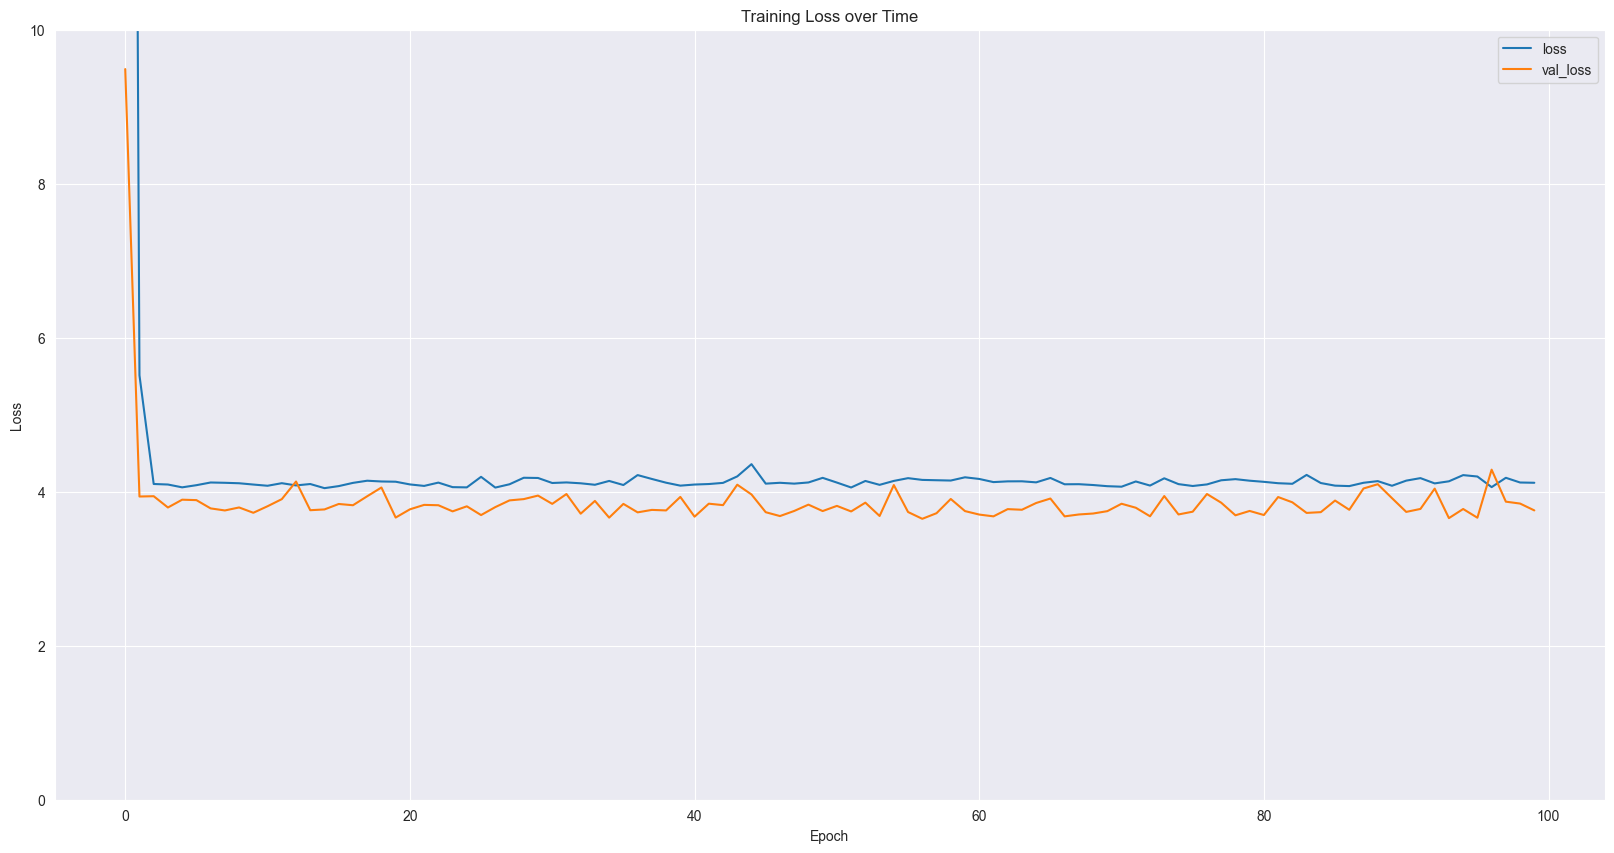

In [97]:
# Utility functions imported from mlutils.py
plot_training_loss(history)


#### Predictions: Feature-Rich Model

We are hoping it did *too* well.


In [98]:
overfit_target = np.array(crabs[PREDICTION_TARGET])
overfit_preds = overfit_model.predict(crabs.drop(columns=[PREDICTION_TARGET])).flatten()

print(overfit_target)
print(overfit_preds)


119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step
[9 6 6 ... 5 6 8]
[10.326385   7.113226   7.544504  ...  5.200285   7.3227177  6.356741 ]


#### Scores: Feature-Rich Model

Metrics used:

- **Mean Squared Error**
    - The best possible score is 0.0, lower values are better.
- **Mean Absolute Error**
    - The best possible score is 0.0, lower values are better. Less sensitive to outliers.
- **Explained Variance Score**
    - The best possible score is 1.0, lower values are worse.
- **R2 Score**
    - The best possible score is 1.0, lower values are worse.
- **Max Error**
    - The max error is the worst possible score. Domain-specific. 10 years is a lot for a crab.


In [99]:
# Utility functions imported from mlutils.py
overfit_scores_df = score_model(overfit_preds, overfit_target, index='overfit')

leaderboard_df = score_combine(leaderboard_df, overfit_scores_df)

leaderboard_df.head()


,mean_squared_error,mean_absolute_error,explained_variance_score,r2_score,max_error
naive,104.776642,9.741818,-64.196121,-690.847528,20.256891
shell_weight,5.109282,1.674861,-0.562407,-0.565380,10.353510
overfit,3.967622,1.463473,0.224211,0.220333,9.284962


### Comparison: Shell Weight vs Feature-Rich

We'll see if this feature-rich model is any better than the Shell Weight model.


<Axes: title={'center': 'Shell Weight vs All Feature Model Scores'}>

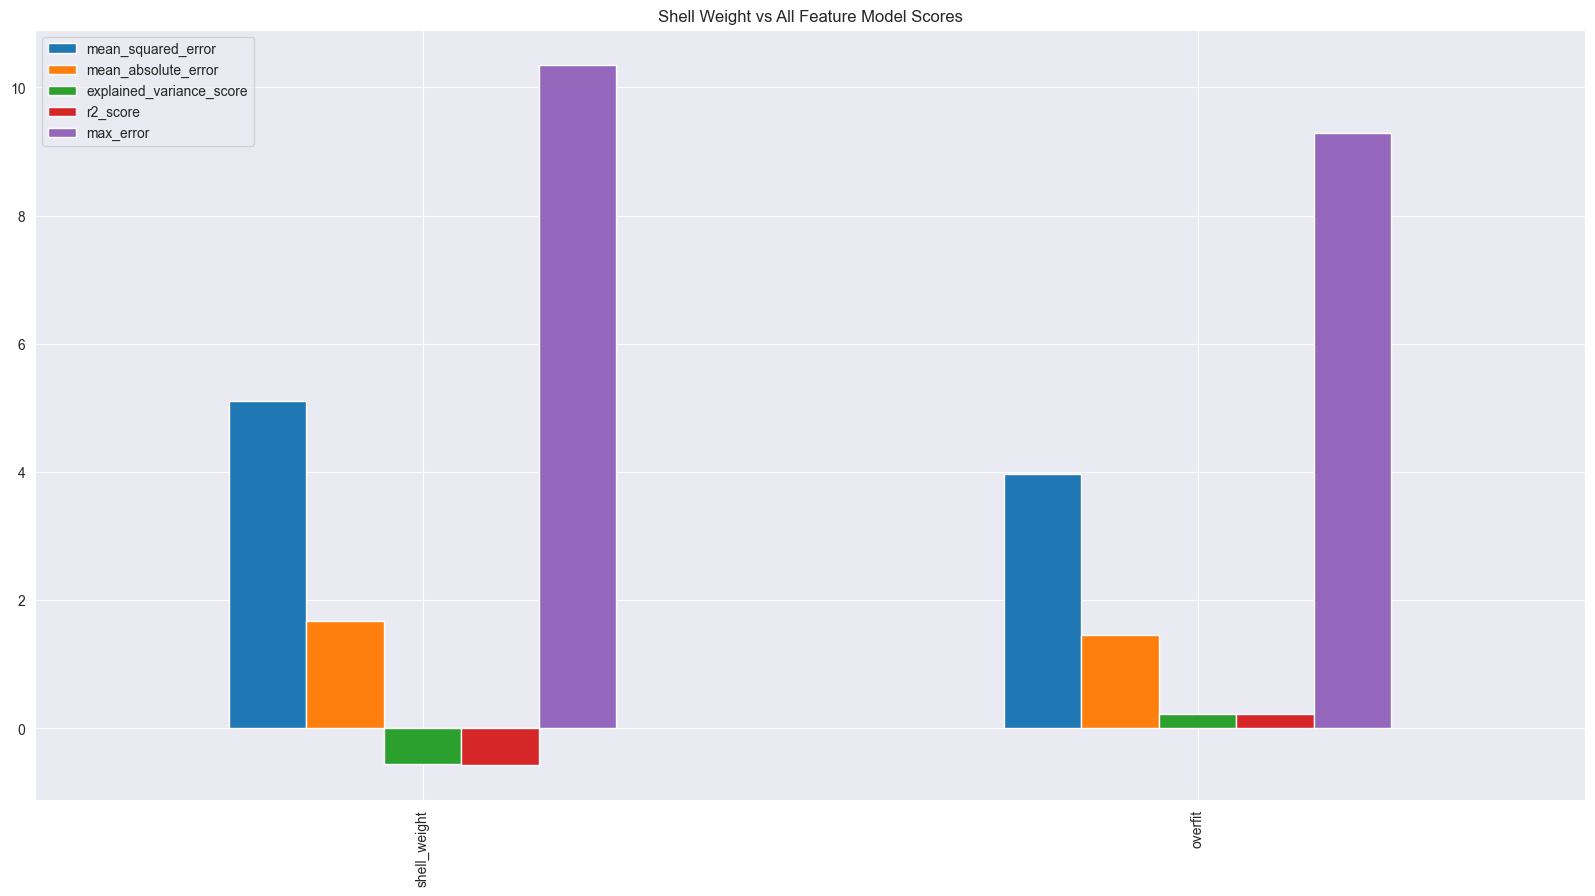

In [100]:
leaderboard_df.drop('naive').plot(kind='bar', title='Shell Weight vs All Feature Model Scores', figsize=(20, 10))


#### Score-by-Score Comparison: Shell Weight vs Feature-Rich

Break down the bar charts into one for each metric.


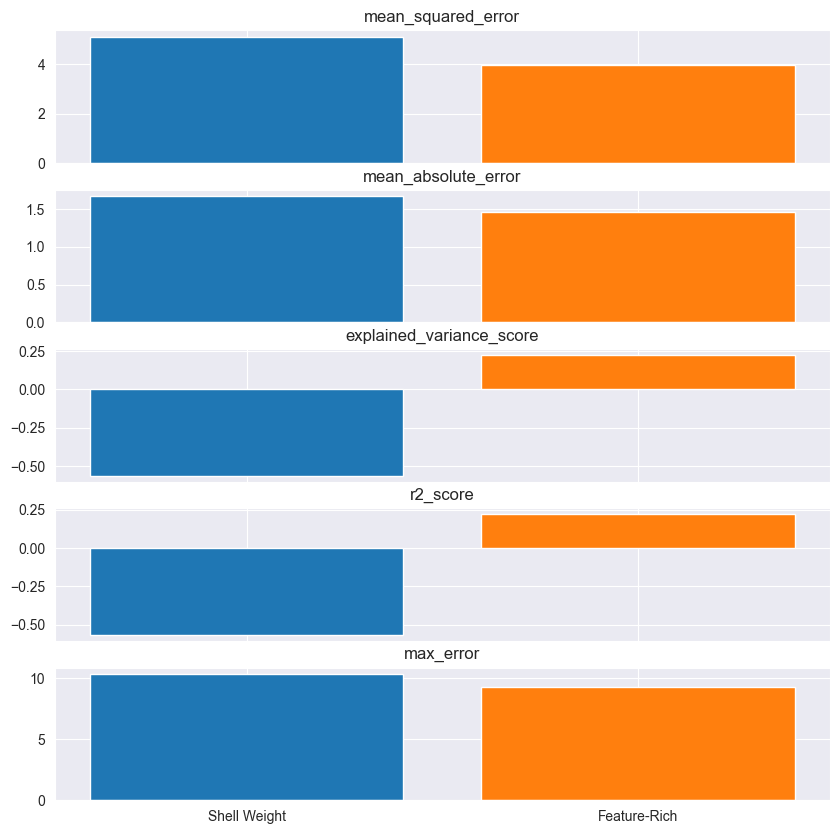

In [101]:
# Utility functions imported from mlutils.py
score_comparator(shell_weight_scores_df, overfit_scores_df, train_label='Shell Weight', test_label='Feature-Rich')


### Observations: Feature-Rich Model

The scores are better than the Shell Weight model, but not by much. We must go deeper!


### Don't Save this Data

We don't want our over-trained model to leak into the [next step](../1-models/models.ipynb).


### Onwards to Model Selection

See the [next section](../1-models/models.ipynb) for model selection.
